In [1]:
import pandas as pd
import os
from operator import contains
from PIL import Image

import os,sys,inspect
import hydra
import omegaconf
import torch
from omegaconf import DictConfig
import numpy as np

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from models import AE
from src import bmw_loader as bloader

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint 
import torchvision as tv
import plotly.express as px

In [2]:
df = pd.read_csv("../data/anomaly_bmw/annotation.csv")

In [3]:
df.head()

Unnamed: 0 lbl_orig              file_name lbl
0           0       IO  ore-bo-labelh50_1.jpg  IO
1           1       IO  ore-bo-labelh50_2.jpg  IO
2           2       IO  ore-bo-labelh50_3.jpg  IO
3           3       IO  ore-bo-labelh50_4.jpg  IO
4           4       IO  ore-bo-labelh50_5.jpg  IO

In [4]:
print(f"Total images {len(df)}")
print(f"There're {len(df) - sum(df.lbl_orig == df.lbl)} images, where lbl_orig and lbl is not the same")
print(f"Using lbl field")

Total images 21993
There're 24 images, where lbl_orig and lbl is not the same
Using lbl field


In [5]:
! ls -1 ../data/anomaly_bmw | grep ".*jpg" | wc -l

     495


Actually have 495 images

In [6]:
actuall_imgs = [f for f in os.listdir('../data/anomaly_bmw') if 'jpg' in f]

In [7]:
out = df.loc[map(contains, [actuall_imgs]*len(df), df['file_name'].tolist())]

In [8]:
out

Unnamed: 0 lbl_orig                file_name  lbl
0             0       IO    ore-bo-labelh50_1.jpg   IO
1             1       IO    ore-bo-labelh50_2.jpg   IO
2             2       IO    ore-bo-labelh50_3.jpg   IO
3             3       IO    ore-bo-labelh50_4.jpg   IO
4             4       IO    ore-bo-labelh50_5.jpg   IO
..          ...      ...                      ...  ...
490         490      NIO  ore-bo-labelh50_492.jpg  NIO
491         491      NIO  ore-bo-labelh50_493.jpg  NIO
492         492      NIO  ore-bo-labelh50_494.jpg  NIO
493         493      NIO  ore-bo-labelh50_495.jpg  NIO
494         494      NIO  ore-bo-labelh50_496.jpg  NIO

[495 rows x 4 columns]

- IO - OK
- NIO - Not OK

In [9]:
'''
import random

good_lbls = out[out.lbl == 'IO']
bad_lbls = out[out.lbl == 'NIO']

label_num_map = {'IO': 0, 'NIO': 1}

train_len = int(len(good_lbls)*0.5)
train_idx = np.random.choice([i for i in range(len(good_lbls))], train_len, replace=False)
train_objs = list(zip(good_lbls.iloc[train_idx].file_name.tolist(), [label_num_map['IO']]*len(train_idx)))
random.shuffle(train_objs)

test_idx = np.array(list((set(range(len(good_lbls))) - set(train_idx))))
test_img_path = good_lbls.iloc[test_idx].file_name.tolist() + bad_lbls.file_name.tolist()
test_labels = [label_num_map['IO']]*len(test_idx) + [label_num_map['NIO']]*len(bad_lbls)
test_objs = list(zip(test_img_path, test_labels))
random.shuffle(test_objs)
'''

"\nimport random\n\ngood_lbls = out[out.lbl == 'IO']\nbad_lbls = out[out.lbl == 'NIO']\n\nlabel_num_map = {'IO': 0, 'NIO': 1}\n\ntrain_len = int(len(good_lbls)*0.5)\ntrain_idx = np.random.choice([i for i in range(len(good_lbls))], train_len, replace=False)\ntrain_objs = list(zip(good_lbls.iloc[train_idx].file_name.tolist(), [label_num_map['IO']]*len(train_idx)))\nrandom.shuffle(train_objs)\n\ntest_idx = np.array(list((set(range(len(good_lbls))) - set(train_idx))))\ntest_img_path = good_lbls.iloc[test_idx].file_name.tolist() + bad_lbls.file_name.tolist()\ntest_labels = [label_num_map['IO']]*len(test_idx) + [label_num_map['NIO']]*len(bad_lbls)\ntest_objs = list(zip(test_img_path, test_labels))\nrandom.shuffle(test_objs)\n"

In [10]:
fig = px.histogram(out, x="lbl")
fig.show()

In [11]:
image = Image.open(f'../data/anomaly_bmw/{actuall_imgs[0]}')

In [12]:
print(image.format, image.mode, image.size)
display(image)

JPEG RGB (2456, 2054)


As we can see, images are very large, we can, of course scale them down so that autoencoder, can be easily trainable (below).

However, we can use image size to our own advatage! We can tile whole image like it's done gigapixel images [here](https://www.sciencedirect.com/science/article/pii/S1361841521003431) And train autoencoder for *each* tile. That way size of the tile will be our parameter which will affect our sensitivity of data drift. Same architecture will remain for data drift, but instead of different averaged classes we will have autoencoders on different regions of image! Which will give us attention map of some kind. Where we will be able to detect anomalies and new classes more perciesly.

Problem with attention map: numbers should be in one tile!

### Questions regarding business process:

- How many cameras are in one production line? 1 camera per production line
- How many production lines are there?
- Are all cameras of the same model?
- Are all cars following the same line/cameras or is there any cameras/production lines specific to some models
- What types of anomalies are there?
- How data drift is defined within this process?

### Things I noted looking at images:

- We have different models
- Some digit/letters in numbers is covered/missed, why?
- Background is blurred on some images, why?
- There're white and black cars, is it artificially made? Last two images are very similar
- Trunc can be open (maybe both?)
- Hood is always open(?)
- There can be ppl in background

Problems:

#### Camera "problems" should be treated as "style"
So of course, we can say that there is data drift (anomaly if we're talking about one image) when camera is moved, or lightning condition are different, but question here can be put differently. We actually can say what's wrong can be with camera: lightning conditions, focus, movement, scratches. And all of these can me modelled (e.g. algoritmically put on images simulating such condition) that gives us two advatages: 1) we can generate data and model drift for such occasions, 2) more interesting, given, that we know such things can happen, can we train an VAEGAN to disentagle style (e.g. camera problems) and features (e.g. cars) and maybe even interpolate car from  information given (e.g. yes, the image is lighted badly, but we can restore bad parts of it and we know with some certainty that this is 320i model and we can say it's not anomaly one) that way we will be more sensitive to react on anomalies.

#### New model on production line: will it be visible? E.g data drift for new class
This is another type of the drift: new class:
I guess for that StyleGAN was used and model evaluation was for new class, question here is why not use classifier for numbers and letters train it on one subset of numbers and use on another? Or why use StyleGAN if you could just simply get the fonts for BMW letters (I belive there should be one).

#### One of the main research question: Can this be done in car-model agnostic way? 

In [13]:
new_image = image.resize((2456//8, 2054//8))

None RGB (307, 256)


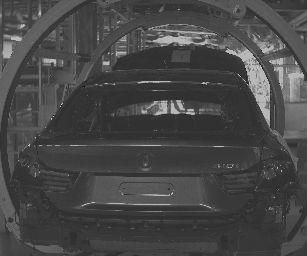

In [14]:
print(new_image.format, new_image.mode, new_image.size)
display(new_image)

In [15]:
cfg = omegaconf.OmegaConf.load('../config/bmw_config.yaml')
cfg.exp.model = "AE"

In [16]:
print(cfg.arch.cnn_enc.input_height, cfg.arch.cnn_enc.input_width)

200 400


In [17]:
cfg.arch.cnn_enc.negative_slope_factor

0.001

In [18]:
transform  = tv.transforms.Compose([tv.transforms.ToPILImage(),
                                    #tv.transforms.Grayscale(num_output_channels=3),
                                    tv.transforms.Resize((cfg.arch.cnn_enc.input_height, cfg.arch.cnn_enc.input_width)),
                                    tv.transforms.ToTensor(), 
                                   ])

In [19]:
out.file_name = out.file_name.apply(lambda x: '../data/anomaly_bmw/' + x)

/Users/pabramov/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
out

Unnamed: 0 lbl_orig                                    file_name  lbl
0             0       IO    ../data/anomaly_bmw/ore-bo-labelh50_1.jpg   IO
1             1       IO    ../data/anomaly_bmw/ore-bo-labelh50_2.jpg   IO
2             2       IO    ../data/anomaly_bmw/ore-bo-labelh50_3.jpg   IO
3             3       IO    ../data/anomaly_bmw/ore-bo-labelh50_4.jpg   IO
4             4       IO    ../data/anomaly_bmw/ore-bo-labelh50_5.jpg   IO
..          ...      ...                                          ...  ...
490         490      NIO  ../data/anomaly_bmw/ore-bo-labelh50_492.jpg  NIO
491         491      NIO  ../data/anomaly_bmw/ore-bo-labelh50_493.jpg  NIO
492         492      NIO  ../data/anomaly_bmw/ore-bo-labelh50_494.jpg  NIO
493         493      NIO  ../data/anomaly_bmw/ore-bo-labelh50_495.jpg  NIO
494         494      NIO  ../data/anomaly_bmw/ore-bo-labelh50_496.jpg  NIO

[495 rows x 4 columns]

In [21]:
bmw_loader = bloader.BMWDataset(out, transforms=transform)

In [22]:
model = AE.AE(cfg)

In [23]:
early_stop_callback = EarlyStopping(monitor= 'train_loss',
                                    min_delta=0.00, 
                                    patience=cfg.exp.early_stopping_patience, 
                                    verbose=False, 
                                    mode='min')
#checkpoint_callback = CustomModelCheckpoint(model=model, verbose=True, monitor='val_loss', mode='min', save_top_k=1)
lr_logging_callback = LearningRateMonitor(logging_interval='epoch')
checkpoint_callback = ModelCheckpoint(save_last=True, 
                                      save_top_k=1, 
                                      monitor="train_loss", 
                                      every_n_epochs=1)
trainer = Trainer(gpus=None,
                  max_epochs=cfg.exp.max_epochs,
                  #auto_lr_find=self.args.optimizer.auto_lr_find,
                  accelerator='dp',
                  log_every_n_steps=5,
                  profiler='simple',
                  check_val_every_n_epoch=cfg.exp.check_val_every_n_epoch,
                  callbacks=[lr_logging_callback, early_stop_callback])



/Users/pabramov/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:782: UserWarning:

You requested distributed training on GPUs, but none is available, so we set backend to `ddp_cpu`.

/Users/pabramov/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:789: UserWarning:

You are running on single node with no parallelization, so distributed has no effect.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [24]:
trainer.fit(model, datamodule=bmw_loader)
#trainer.test(model, datamodule=mvtec_loader)


  | Name    | Type            | Params
--------------------------------------------
0 | encoder | BMW_CNN_Encoder | 5.0 M 
1 | decoder | BMW_CNN_Decoder | 164 M 
--------------------------------------------
169 M     Trainable params
0         Non-trainable params
169 M     Total params
676.752   Total estimated model params size (MB)
/Users/pabramov/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning:

The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



/Users/pabramov/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1047: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...

